In [1]:
# ============================================
# 1: Install Required Packages
# ============================================
!pip install transformers datasets evaluate scikit-learn
!pip install --upgrade transformers
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [1]:
# ============================================
# 2: Import Libraries
# ============================================
import torch
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
# ============================================
# 3: Load and Preprocess Dataset
# ============================================
# Load dataset (Amazon Polarity)
dataset = load_dataset("amazon_polarity")

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["content"], truncation=True)

# Tokenize dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Take smaller subset for quicker training/testing
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(20000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(4000))

# Show sample examples from dataset
for i in range(5):
    item = small_train_dataset[i]
    decoded_text = tokenizer.decode(item['input_ids'], skip_special_tokens=True)
    print(f"\nExample {i+1}")
    print(f"Text: {decoded_text}")
    print(f"Label: {'Positive' if item['label'] == 1 else 'Negative'}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]


Example 1
Text: all the pretty people in this film. even the rudy character played by michael madsen. this is adapted from a jim thompson novel for cryin ' out loud! these are supposed to be marginal characters, not fashion models. though mcqueen and mcgraw were attractive ( but check out mcqueen ' s crummy prison haircut ) they were believable in the role. baldwin and bassinger seem like movie stars trying to act like hard cases. action wise, the robbery scene in the pekinpah version was about 100 times more exciting and suspenseful than anything in this re - make.
Label: Negative

Example 2
Text: i know that tom robbins has a loyal following and i started the book with high expectations. however, i did not enjoy this book as it was too much work to follow his confused logic. i think that he was under the influence during most of time that he wrote.
Label: Negative

Example 3
Text: this type of spaetzle maker is easier to manuveur than the old press kind and much easier on the hands.

In [6]:
df = pd.DataFrame(dataset["train"])


In [7]:
df.head()

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [20]:

df["label_text"] = df["label"].apply(lambda x: "Positive" if x == 1 else "Negative")
df["text_length"] = df["content"].apply(lambda x: len(x.split()))

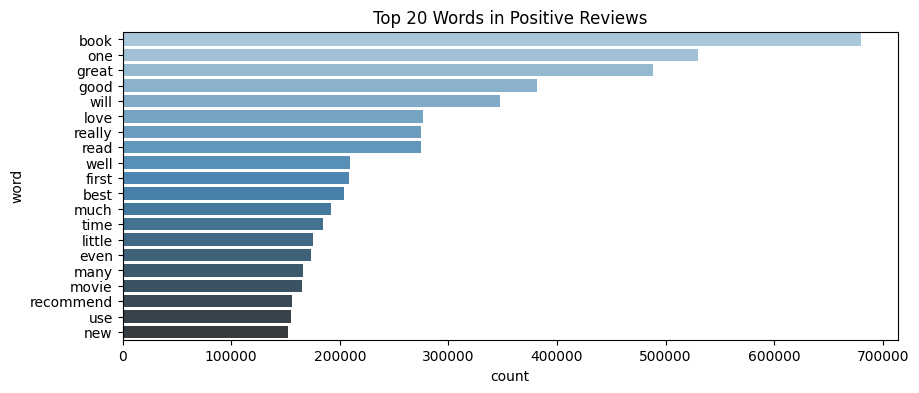

/tmp/ipython-input-21-4093866130.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x="count", y="word", palette="Reds_d")


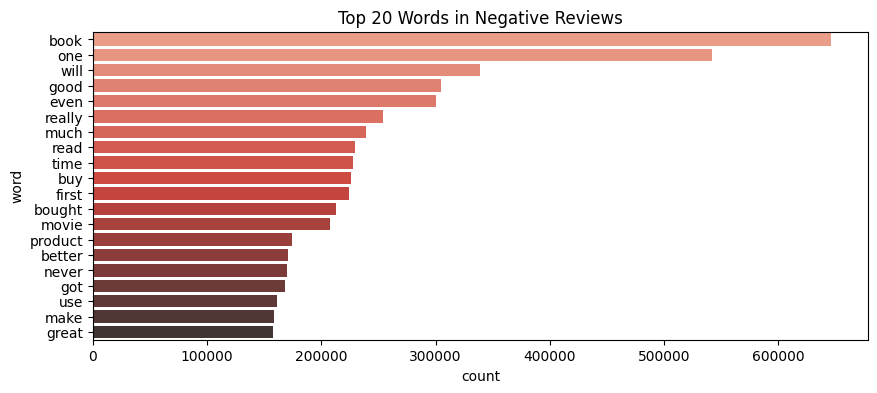

/tmp/ipython-input-21-4093866130.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_lengths, x="label_text", y="text_length", palette="pastel")


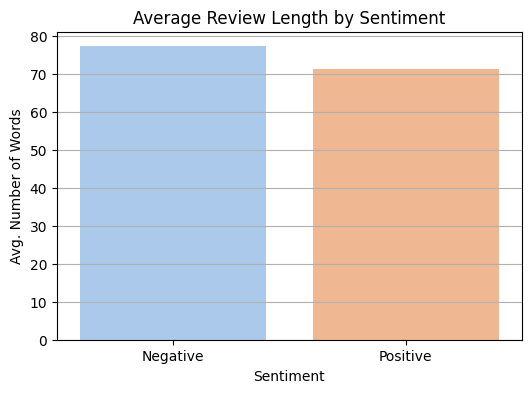

In [21]:
# ============================================
# 4: Exploratory Data Analysis (EDA)
# ============================================
# Separate positive and negative reviews
positive_reviews = df[df["label"] == 1]["content"]
negative_reviews = df[df["label"] == 0]["content"]

# Define stopwords
stopwords = set(STOPWORDS)

# Function to get most common words
def get_top_words(texts, n=20):
    all_words = " ".join(texts).lower().split()
    filtered_words = [word for word in all_words if word not in stopwords and word.isalpha()]
    return Counter(filtered_words).most_common(n)

# Get top words
top_pos = get_top_words(positive_reviews)
top_neg = get_top_words(negative_reviews)

# Plot top words - positive
top_words_df = pd.DataFrame(top_pos, columns=["word", "count"])
plt.figure(figsize=(10, 4))
sns.barplot(data=top_words_df, x="count", y="word", palette="Blues_d")
plt.title("Top 20 Words in Positive Reviews")
plt.show()

# Plot top words - negative
top_words_df = pd.DataFrame(top_neg, columns=["word", "count"])
plt.figure(figsize=(10, 4))
sns.barplot(data=top_words_df, x="count", y="word", palette="Reds_d")
plt.title("Top 20 Words in Negative Reviews")
plt.show()

# Plot average text length per sentiment
avg_lengths = df.groupby("label_text")["text_length"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_lengths, x="label_text", y="text_length", palette="pastel")
plt.title("Average Review Length by Sentiment")
plt.ylabel("Avg. Number of Words")
plt.xlabel("Sentiment")
plt.grid(True, axis="y")
plt.show()

In [10]:
# ============================================
# 5: Load Pretrained BERT Model
# ============================================
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# ============================================
# 6: Define Metrics
# ============================================
eval_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return eval_accuracy.compute(predictions=predictions, references=labels)


In [13]:
# ============================================
# 7: Training Setup
# ============================================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [14]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

/tmp/ipython-input-14-491460070.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.221700,0.175597,0.935500
2,0.128800,0.247035,0.929500
3,0.063900,0.285126,0.938750
4,0.028100,0.320273,0.939500


In [15]:
# ============================================
# 8: Evaluate Model Performance
# ============================================

# Classification report
predictions_output = trainer.predict(small_test_dataset)
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=-1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# ============================================
# Save Model and Metrics
# ============================================
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

# Save metrics and state
metrics = train_result.metrics
trainer.save_metrics("train", metrics)
trainer.save_state()


Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.91      0.93      1962
    Positive       0.92      0.96      0.94      2038

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



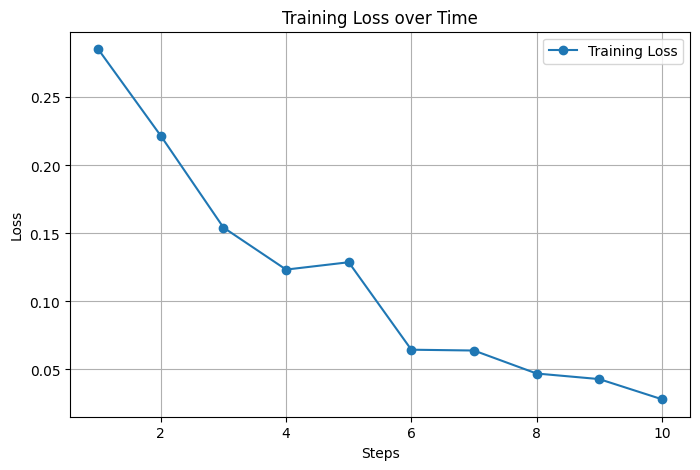

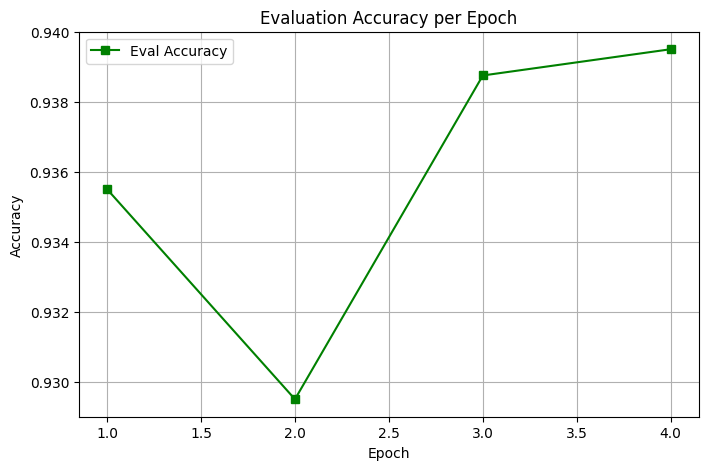


Evaluation Results: {'eval_loss': 0.17559659481048584, 'eval_accuracy': 0.9355, 'eval_runtime': 10.8017, 'eval_samples_per_second': 370.313, 'eval_steps_per_second': 23.145, 'epoch': 4.0}


In [16]:
# ============================================
# 9: Plot Training Progress
# ============================================
# Training loss plot
training_loss = train_result.training_loss
history = trainer.state.log_history
loss_vals = [log["loss"] for log in history if "loss" in log]
epochs = list(range(1, len(loss_vals) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_vals, marker='o', label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation accuracy plot
eval_acc_vals = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
eval_epochs = list(range(1, len(eval_acc_vals) + 1))

plt.figure(figsize=(8, 5))
plt.plot(eval_epochs, eval_acc_vals, marker='s', color='green', label="Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation
results = trainer.evaluate()
print("\nEvaluation Results:", results)


In [17]:
# ============================================
# 10: Run Predictions on Custom Inputs
# ============================================
example_texts = [
    "This product was amazing, exceeded my expectations!",
    "Totally not worth the money, very disappointed.",
    "The item arrived broken and I couldn't return it.",
]

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and move to device
inputs = tokenizer(example_texts, return_tensors="pt", padding=True, truncation=True)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Perform inference
with torch.no_grad():
    logits = model(**inputs).logits
    predictions = torch.argmax(logits, dim=-1)

print("\nExample Predictions:")
for text, pred in zip(example_texts, predictions):
    sentiment = "Positive" if pred.item() == 1 else "Negative"
    print(f"\nText: {text}\nPredicted Sentiment: {sentiment}")


Example Predictions:

Text: This product was amazing, exceeded my expectations!
Predicted Sentiment: Positive

Text: Totally not worth the money, very disappointed.
Predicted Sentiment: Negative

Text: The item arrived broken and I couldn't return it.
Predicted Sentiment: Negative
